### Gather dependencies

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
# from sodapy import Socrata
from config import census_key
import pprint
import requests
import csv
import os

### Function for quickly calling a DataFrame

In [2]:
# Function for quickly assempling a DataFrame
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

### Create DataFrame for CDC Data

In [3]:
cdc_data = pd.read_csv("../Project_1/cdc_data.csv")
cdc_data
cdc_df = pd.DataFrame(cdc_data)
cdc_df

# Choose the columns we want and rename anything that isn't clear
cdc_df = cdc_df[['case_month', 'res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 'current_status']]
cdc_df = cdc_df.rename(columns={
    'res_state': 'State',
    'res_county': 'County',
    'ethnicity': 'Ethnicity',
    'current_status': 'Infection Status',
    'race':'Race'
})

# Drop "Unkown" race from dataset
cdc_df = cdc_df.loc[cdc_df['Race']!= 'Unknown', :]

# Set Infections to 1 and replace the various races with values that are compatible with the census data
cdc_df['Infections'] = 1
cdc_df['Race'] = cdc_df['Race'].replace('White', 'Caucasian')
cdc_df['Race'] = cdc_df['Race'].replace('Black', 'African American')
cdc_df['Race'] = cdc_df['Race'].replace('American Indian/Alaska Native', 'Native American')
cdc_df['Race'] = cdc_df['Race'].replace('Multiple/Other', 'Other')
cdc_df['Race'] = np.where(np.logical_and(cdc_df['Race'] == 'Caucasian', cdc_df['Ethnicity'] == 'Hispanic/Latino'), 'Hispanic', cdc_df['Race'])

# NOTE: It's not clear what happens with Hawaiian here. 

cdc_df.head()

,case_month,State,County,age_group,sex,Race,Ethnicity,Infection Status,Infections
0,2021-11,MN,STEELE,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
2,2021-11,MN,STEARNS,50 to 64 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
3,2020-05,MN,KANDIYOHI,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
4,2021-05,MN,ANOKA,18 to 49 years,Male,NaN,NaN,Laboratory-confirmed case,1
5,2020-04,MN,CLAY,65+ years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1


### Drop NaN and compile totals by county and race

In [4]:
# Drop NaNs and then group by County and Race
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
cdc_df = cdc_grouped_county.count()
cdc_df.reset_index(inplace=True)
cdc_df


,County,Race,Infections
0,ANOKA,African American,2864
1,ANOKA,Asian,1732
2,ANOKA,Caucasian,24501
3,ANOKA,Hispanic,746
4,ANOKA,Native American,73
...,...,...,...
172,WRIGHT,African American,107
173,WRIGHT,Asian,49
174,WRIGHT,Caucasian,10656
175,WRIGHT,Hispanic,109


### Create poverty DataFrame based on US Census

In [5]:
# Poverty DataFrame By Race - 2020

url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B17001_002E,B17001A_002E,B17001B_002E,B17001C_002E,B17001D_002E,B17001E_002E,B17001F_002E,B17001G_002E,B17001H_002E,B17001I_002E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)
response
poverty_df = json_to_dataframe(response)

# Split NAME into county & state
name = poverty_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = poverty_df['County'] = name[0]
STATE = poverty_df['State'] = name[1]
poverty_df.drop(columns=["NAME"], inplace=True)
poverty_df['Caucasian2'] = poverty_df['B17001A_002E'].astype(int) - poverty_df['B17001I_002E'].astype(int)
poverty_df['Other'] = poverty_df['B17001F_002E'].astype(int) + poverty_df['B17001G_002E'].astype(int)

# Get the columns we want
poverty_df = poverty_df[['County', 'State','B17001_002E','Caucasian2', 'B17001B_002E','B17001C_002E','B17001D_002E','B17001E_002E','Other','B17001I_002E']]

# Rename columns to something intelligible
poverty_df = poverty_df.rename(columns={
    'B17001_002E':'Poverty Total',
    'Caucasian2':'Caucasian',
    'B17001B_002E':'African American',
    'B17001C_002E':'Native American',
    'B17001D_002E':'Asian',
    'B17001E_002E':'Hawaiian', # I had to change this from Native Hawaiian to Hawaiian for compatibility with the rest - Dom
    'B17001I_002E':'Hispanic' 
    })

# # Remove ...County from County in dataframe
poverty_df['County'] = poverty_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
poverty_df['County'] = poverty_df['County'].str.strip()

# And then convert the county name to uppercase
poverty_df['County'] = poverty_df['County'].str.upper()

poverty_df['Year'] = 2020
#poverty_df.to_csv("../Project_1/population_in_poverty.csv")
poverty_df



,County,State,Poverty Total,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic,Year
0,ANOKA,Minnesota,20270,11778,3697,327,953,0,1964,1551,2020
1,BECKER,Minnesota,3588,2296,17,709,45,0,381,140,2020
2,BELTRAMI,Minnesota,8167,3657,310,3056,39,0,734,371,2020
3,BENTON,Minnesota,3357,2605,333,19,73,0,205,122,2020
4,BIG STONE,Minnesota,596,596,0,0,0,0,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...
82,RENVILLE,Minnesota,1373,717,29,97,8,0,245,277,2020
83,ROSEAU,Minnesota,1133,971,6,67,11,0,28,50,2020
84,SHERBURNE,Minnesota,4953,2857,578,171,251,0,737,359,2020
85,STEELE,Minnesota,2887,1835,426,113,3,0,149,361,2020


In [6]:
# Choose only the columns we need
poverty_df = poverty_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
poverty_df

,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,11778,3697,327,953,0,1964,1551
1,BECKER,2296,17,709,45,0,381,140
2,BELTRAMI,3657,310,3056,39,0,734,371
3,BENTON,2605,333,19,73,0,205,122
4,BIG STONE,596,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
82,RENVILLE,717,29,97,8,0,245,277
83,ROSEAU,971,6,67,11,0,28,50
84,SHERBURNE,2857,578,171,251,0,737,359
85,STEELE,1835,426,113,3,0,149,361


In [7]:
# Use melt to convert this into a format similar to the CDC data
poverty_df = poverty_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                    'Hawaiian', 'Other', 'Hispanic'], \
                                                     var_name='Race', value_name='Poverty')
poverty_gb = poverty_df.groupby(['County', 'Race'])
poverty_df = poverty_gb.sum()
poverty_df.reset_index(inplace=True)
poverty_df

,County,Race,Poverty
0,AITKIN,African American,13
1,AITKIN,Asian,0
2,AITKIN,Caucasian,1711
3,AITKIN,Hawaiian,0
4,AITKIN,Hispanic,45
...,...,...,...
604,YELLOW MEDICINE,Caucasian,722
605,YELLOW MEDICINE,Hawaiian,0
606,YELLOW MEDICINE,Hispanic,53
607,YELLOW MEDICINE,Native American,30


### Create population DataFrame by county and race

In [8]:
# Population by county, by race
url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E&for=county:*&in=state:27&key={0}".format(census_key)


response = requests.request("GET", url)
response
response_df = json_to_dataframe(response)
response_df = response_df.rename(columns={
    'B03002_001E': 'Population Total',
    'B03002_003E': 'Caucasian',
    'B03002_004E': 'African American',
    'B03002_005E': 'Native American',
    'B03002_006E': 'Asian',
    'B03002_007E': 'Hawaiian',
    'B03002_012E': 'Hispanic'
})
response_df['Other'] = response_df['B03002_008E'].astype(int) + response_df['B03002_009E'].astype(int)
mn_pop_df = response_df

# Split NAME into county & state
name = mn_pop_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = mn_pop_df['County']=name[0]
STATE = mn_pop_df['State']=name[1]
mn_pop_df.drop(columns=["NAME"], inplace=True)

# # Remove ...County from County in dataframe
mn_pop_df['County'] = mn_pop_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
mn_pop_df['County'] = mn_pop_df['County'].str.strip()

# # Upper case for County
mn_pop_df['County'] = mn_pop_df['County'].str.upper()
mn_pop_df = mn_pop_df[['County', 'Population Total', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']]
mn_pop_df.to_csv("../Project_1/mn_population by race.csv")
mn_pop_df


,County,Population Total,Caucasian,African American,Native American,Asian,Hawaiian,Hispanic,Other
0,ANOKA,353775,283436,23534,1788,16082,86,16769,12080
1,BECKER,34227,29290,146,1938,209,6,738,1900
2,BELTRAMI,46784,33506,399,8920,295,36,1114,2514
3,BENTON,40476,35979,1876,49,378,0,1086,1108
4,BIG STONE,4974,4787,3,3,0,0,102,79
...,...,...,...,...,...,...,...,...,...
82,RENVILLE,14572,12741,67,186,108,0,1268,202
83,ROSEAU,15259,13876,124,254,399,0,223,383
84,SHERBURNE,96015,86342,2658,403,1206,0,2577,2829
85,STEELE,36710,31640,1225,119,150,6,2913,657


### Coordinates for heat map -- if time permits

In [9]:
# Get the coordinates of counties in MN
url = "https://en.wikipedia.org/wiki/User:Michael_J/County_table"

table = pd.read_html(url)
df = table[0]
Counties = df.loc[df['State'] == "MN", : ]
counties_df = Counties[['County [2]', 'Latitude', 'Longitude']]
counties_df#.to_csv("../Project_1/county_geo.csv")  

,County [2],Latitude,Longitude
1314,Aitkin,+46.602446°,–93.419760°
1315,Anoka,+45.274110°,–93.242723°
1316,Becker,+46.937629°,–95.741757°
1317,Beltrami,+47.878825°,–94.986698°
1318,Benton,+45.701227°,–94.001440°
...,...,...,...
1396,Watonwan,+43.978366°,–94.614128°
1397,Wilkin,+46.362335°,–96.476657°
1398,Winona,+43.982268°,–91.776708°
1399,Wright,+45.175091°,–93.966397°


In [10]:
# Choose only the columns we need
mn_pop_df = mn_pop_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
mn_pop_df


,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,283436,23534,1788,16082,86,12080,16769
1,BECKER,29290,146,1938,209,6,1900,738
2,BELTRAMI,33506,399,8920,295,36,2514,1114
3,BENTON,35979,1876,49,378,0,1108,1086
4,BIG STONE,4787,3,3,0,0,79,102
...,...,...,...,...,...,...,...,...
82,RENVILLE,12741,67,186,108,0,202,1268
83,ROSEAU,13876,124,254,399,0,383,223
84,SHERBURNE,86342,2658,403,1206,0,2829,2577
85,STEELE,31640,1225,119,150,6,657,2913


In [11]:
# Use melt to convert this into a format similar to the CDC data
pop_df = mn_pop_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                      'Hawaiian', 'Other', 'Hispanic'], \
                                                      var_name='Race', value_name='Population')
pop_gb = pop_df.groupby(['County', 'Race'])
pop_df = pop_gb.sum()
pop_df.reset_index(inplace=True)
pop_df

,County,Race,Population
0,AITKIN,African American,61
1,AITKIN,Asian,40
2,AITKIN,Caucasian,14831
3,AITKIN,Hawaiian,9
4,AITKIN,Hispanic,216
...,...,...,...
604,YELLOW MEDICINE,Caucasian,8725
605,YELLOW MEDICINE,Hawaiian,0
606,YELLOW MEDICINE,Hispanic,468
607,YELLOW MEDICINE,Native American,229


### Merge the datasets

In [12]:
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'])
merged_df.dtypes

County        object
Race          object
Population    object
Poverty       object
Infections     int64
dtype: object

In [13]:
# Edited merge_df for nan infections to be 0
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'], how = "left")
merged_df["Infections"] = merged_df["Infections"].fillna(0)
merged_df

# Convert all numerical values in merged_df from strings to int
merged_df["Population"] = merged_df["Population"].astype(int)
merged_df["Poverty"] = merged_df["Poverty"].astype(int)
merged_df["Infections"] = merged_df["Infections"].astype(int)

# Calculate poverty and infection rates
poverty_rate = []
infection_rate = []

i = 0
while i < len(merged_df):
    if merged_df["Population"][i] == 0:
        poverty_rate.append(0)
        infection_rate.append(0)
    else: 
        poverty_rate.append(merged_df["Poverty"][i] / merged_df["Population"][i])
        infection_rate.append(merged_df["Infections"][i] / merged_df["Population"][i])
    i += 1
    
merged_df["Poverty Rate"] = poverty_rate
merged_df["Infection Rate"] = infection_rate

# merged_df[merged_df["County"] == "CROW WING"]    
merged_df.tail(100)

,County,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate
509,STEARNS,Native American,289,30,7,0.103806,0.024221
510,STEARNS,Other,4309,1448,116,0.336041,0.026920
511,STEELE,African American,1225,426,45,0.347755,0.036735
512,STEELE,Asian,150,3,0,0.020000,0.000000
513,STEELE,Caucasian,31640,1835,2666,0.057996,0.084260
...,...,...,...,...,...,...,...
604,YELLOW MEDICINE,Caucasian,8725,722,0,0.082751,0.000000
605,YELLOW MEDICINE,Hawaiian,0,0,0,0.000000,0.000000
606,YELLOW MEDICINE,Hispanic,468,53,0,0.113248,0.000000
607,YELLOW MEDICINE,Native American,229,30,0,0.131004,0.000000


# Mauvonte's Code Starts Here

In [14]:
#Mean and Median
mean_df = merged_df.groupby('Race').mean()
mean_df.reset_index()

,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,African American,4075.172414,1053.126437,419.160920,0.263118,0.023234
1,Asian,3139.080460,399.045977,238.988506,0.137476,0.010979
2,Caucasian,50833.218391,3045.620690,3776.333333,0.075060,0.044010
3,Hawaiian,21.896552,4.114943,0.000000,0.052836,0.000000
4,Hispanic,3536.494253,602.609195,117.988506,0.204458,0.010016
5,Native American,556.425287,189.965517,35.000000,0.310673,0.012460
6,Other,2207.436782,581.206897,63.206897,0.394056,0.006409


7       2864
28       104
42       213
91       190
126     3433
182    17231
231      103
378     1078
427     6546
455      358
476      660
483      267
497      182
504     1359
567     1278
595      107
Name: Infections, dtype: int64
9      24501
128    26590
184    65471
380    11369
429    23524
478    10607
499    14841
506    14061
569    17625
597    10656
Name: Infections, dtype: int64
8      1732
43       30
64      123
85       14
92        6
127    1551
162      39
183    7448
288      10
344      97
365      77
379     528
428    6853
456      37
477     546
484      14
498      36
505     131
568    1463
589       5
596      49
Name: Infections, dtype: int64
11      746
67      179
95       87
130    1532
165     141
186    3411
319     131
347     266
368     144
382     303
431    1494
459     235
480     368
515     122
571     576
599     109
Name: Infections, dtype: int64
Series([], Name: Infections, dtype: int64)
13      348
27       33
48       21
69       49
97 

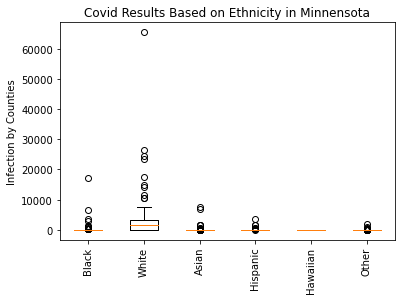

In [15]:
#find quartiles and upper, lower bound, outliers

def boxplot(race):
    covid_box = merged_df.loc[merged_df['Race'] == race]['Infections']
    quartiles = covid_box.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    outliers = covid_box.loc[(covid_box < lower_bound) | (covid_box > upper_bound)]
    print(outliers)
    return covid_box


race_1 = boxplot('African American')
race_2 = boxplot('Caucasian')
race_3 = boxplot('Asian')
race_4 = boxplot('Hispanic')
#race_5 = boxplot('American Indian/Alaskan Native')
race_6 = boxplot('Hawaiian')
race_7 = boxplot('Other')

plt.boxplot([race_1, race_2, race_3, race_4, race_6, race_7], labels=['Black', 'White', 'Asian', 'Hispanic',  'Hawaiian', 'Other'])
plt.ylabel('Infection by Counties')
plt.title('Covid Results Based on Ethnicity in Minnensota')
plt.xticks(rotation=90)
plt.show()


Putting stat summary into dataframe


In [16]:
# Statistics by county
#lief's groupby
merged_county_gb = merged_df.groupby(["County"])

county_pop_stats = merged_county_gb["Population"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_pov_stats = merged_county_gb["Poverty"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_inf_stats = merged_county_gb["Infections"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_pov_rate_stats = merged_county_gb["Poverty Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_inf_rate_stats = merged_county_gb["Infection Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])

In [17]:
 county_pop_stats

,max,min,mean,median,var,std,sem
County,,,,,,,
AITKIN,14831,9,2260.857143,216.0,3.074236e+07,5544.579738,2095.654159
ANOKA,283436,86,50539.285714,16082.0,1.061654e+10,103036.595662,38944.172580
BECKER,29290,6,4889.571429,738.0,1.164207e+08,10789.842907,4078.177288
BELTRAMI,33506,36,6683.428571,1114.0,1.495583e+08,12229.401919,4622.279451
BENTON,35979,0,5782.285714,1086.0,1.777527e+08,13332.393918,5039.171241
...,...,...,...,...,...,...,...
WATONWAN,7782,0,1557.571429,86.0,8.594244e+06,2931.594154,1108.038440
WILKIN,5819,0,894.857143,56.0,4.719702e+06,2172.487624,821.123140
WINONA,46137,0,7249.142857,1003.0,2.943739e+08,17157.327263,6484.860157


In [18]:
# county_inf_rate_stats.T

In [19]:
# merge the county_pov_stats df with county_pove_rate_stats
merged_county_pov_stats_df = pd.merge(county_pov_stats, county_pov_rate_stats, on='County',  how='inner')

#rename columns
col_names = {'max_x':'Cty_Pov_Stats_Max',
            'min_x' :'Cty_Pov_Stats_Min',
            'mean_x' :'Cty_Pov_Stats_Mean',
            'median_x':'Cty_Pov_Stats_Median',
            'var_x':'Cty_Pov_Stats_Variance',
            'std_x':'Cty_Pov_Stats_Std',
            'sem_x':'Cty_Pov_Stats_SEM',
            'max_y':'Cty_Pov_Rate_Max',
            'min_y':'Cty_Pov_Rate_Min',
            'mean_y':'Cty_Pov_Rate_Mean',
            'median_y':'Cty_Pov_Rate_Median',
            'var_y':'Cty_Pov_Rate_Variance',
            'std_y':'Cty_Pov_Rate_Std',
            'sem_y':'Cty_Pov_Rate_SEM'}

merged_county_pov_stats_df = merged_county_pov_stats_df.rename(columns=col_names)
#merged_county_pov_stats_df

            


In [20]:
#merge county_inf_stats df with county_inf_rate_stats 

merged_county_inf_stats_df = pd.merge(county_inf_stats, county_inf_rate_stats, on='County', how='inner')

#rename columns

col_names2 = {
            'max_x':'Cty_Infect_Stats_Max',
            'min_x':'Cty_Infect_Stats_Min',
            'mean_x':'Cty_Infect_Stats_Mean',
            'median_x':'Cty_Infect_Stats_Median',
            'var_x':'Cty_Infect_Stats_Variance',
            'std_x':'Cty_Infect_Stats_Std',
            'sem_x':'Cty_Infect_Stats_SEM',
            'max_y':'Cty_Infect_Rate_Max',
            'min_y':'Cty_Infect_Rate_Min',
            'mean_y':'Cty_Infect_Rate_Mean',
            'median_y':'Cty_Infect_Rate_Median',
            'var_y':'Cty_Infect_Rate_Variance',
            'std_y':'Cty_Infect_Rate_Std',
            'sem_y':'Cty_Infect_Rate_SEM'}

merged_county_inf_stats_df = merged_county_inf_stats_df.rename(columns=col_names2)
#merged_county_inf_stats_df

In [21]:
#merge both df containing the county poverty and county infection
merged_pov_inf_df = pd.merge(merged_county_inf_stats_df, merged_county_pov_stats_df, on='County', how='left')
#merged_pov_inf_df


In [22]:
#merge the merged_pov_inf_df with county_pop_stats
merged_county_data = pd.merge(merged_pov_inf_df, county_pop_stats, on='County', how='left')
#rename population columns
col_names3 = {
            'max':'Cty_Population_Max',
            'min':'Cty_Population_Min',
            'mean':'Cty_Population_Mean',
            'median':'Cty_Population_Median',
            'var': 'Cty_Population_Variance',
            'std': 'Cty_Population_Std',
            'sem': 'Cty_Population_SEM',
            }
merged_county_data = merged_county_data.rename(columns=col_names3)
merged_county_data

,Cty_Infect_Stats_Max,Cty_Infect_Stats_Min,Cty_Infect_Stats_Mean,Cty_Infect_Stats_Median,Cty_Infect_Stats_Variance,Cty_Infect_Stats_Std,Cty_Infect_Stats_SEM,Cty_Infect_Rate_Max,Cty_Infect_Rate_Min,Cty_Infect_Rate_Mean,...,Cty_Pov_Rate_Variance,Cty_Pov_Rate_Std,Cty_Pov_Rate_SEM,Cty_Population_Max,Cty_Population_Min,Cty_Population_Mean,Cty_Population_Median,Cty_Population_Variance,Cty_Population_Std,Cty_Population_SEM
County,,,,,,,,,,,,,,,,,,,,,
AITKIN,0,0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.010589,0.102903,0.038894,14831,9,2260.857143,216.0,3.074236e+07,5544.579738,2095.654159
ANOKA,24501,0,4323.428571,746.0,8.022334e+07,8956.748180,3385.332606,0.121696,0.0,0.061423,...,0.004863,0.069733,0.026356,283436,86,50539.285714,16082.0,1.061654e+10,103036.595662,38944.172580
BECKER,1992,0,317.428571,0.0,5.524543e+05,743.272686,280.930669,0.117647,0.0,0.026673,...,0.013635,0.116767,0.044134,29290,6,4889.571429,738.0,1.164207e+08,10789.842907,4078.177288
BELTRAMI,2216,0,473.714286,3.0,7.455022e+05,863.424715,326.343867,0.119283,0.0,0.029438,...,0.063861,0.252707,0.095514,33506,36,6683.428571,1114.0,1.495583e+08,12229.401919,4622.279451
BENTON,4164,0,611.571429,1.0,2.455287e+06,1566.935423,592.245921,0.115734,0.0,0.026132,...,0.014906,0.122091,0.046146,35979,0,5782.285714,1086.0,1.777527e+08,13332.393918,5039.171241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WATONWAN,0,0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,1.507349,1.227741,0.464043,7782,0,1557.571429,86.0,8.594244e+06,2931.594154,1108.038440
WILKIN,0,0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.129463,0.359810,0.135995,5819,0,894.857143,56.0,4.719702e+06,2172.487624,821.123140
WINONA,3977,0,574.857143,5.0,2.250758e+06,1500.252693,567.042218,0.086200,0.0,0.021889,...,0.022250,0.149166,0.056379,46137,0,7249.142857,1003.0,2.943739e+08,17157.327263,6484.860157


In [23]:
# Statistics by race

merged_race_gb = merged_df.groupby(["Race"])

race_pop_stats = merged_race_gb["Population"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
race_pov_stats = merged_race_gb["Poverty"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
race_inf_stats = merged_race_gb["Infections"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
race_pov_rate_stats = merged_race_gb["Poverty Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
race_inf_rate_stats = merged_race_gb["Infection Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])

In [24]:
#merge race poverty df's 
merged_race_pov_stats = pd.merge(race_pov_stats, race_pov_rate_stats, on='Race', how='inner')
rc_names = {
            'max_x':'Race_Poverty_Max',
            'min_x':'Race_Poverty_Min',
            'mean_x':'Race_Poverty_Mean',
            'median_x':'Race_Poverty_Median',
            'var_x': 'Race_Poverty_Variance',
            'std_x': 'Race_Poverty_Std',
            'sem_x': 'Race_Poverty_SEM',
            'max_y': 'Race_Poverty_Rate_Max',
            'min_y': 'Race_Poverty_Rate_Min',
            'mean_y': 'Race_Poverty_Rate_Mean',
            'median_y': 'Race_Poverty_Rate_Median',
            'var_y': 'Race_Poverty_Rate_Variance',
            'std_y': 'Race_Poverty_Rate_Std',
            'sem_y': 'Race_Poverty_Rate_SEM'
            }
merged_race_pov_stats = merged_race_pov_stats.rename(columns=rc_names)
merged_race_pov_stats

,Race_Poverty_Max,Race_Poverty_Min,Race_Poverty_Mean,Race_Poverty_Median,Race_Poverty_Variance,Race_Poverty_Std,Race_Poverty_SEM,Race_Poverty_Rate_Max,Race_Poverty_Rate_Min,Race_Poverty_Rate_Mean,Race_Poverty_Rate_Median,Race_Poverty_Rate_Variance,Race_Poverty_Rate_Std,Race_Poverty_Rate_SEM
Race,,,,,,,,,,,,,,
African American,44032,0,1053.126437,32.0,2.602437e+07,5101.408232,546.928371,2.666667,0.000000,0.263118,0.220779,0.099530,0.315485,0.033823
Asian,16965,0,399.045977,18.0,3.923613e+06,1980.811191,212.365251,0.615385,0.000000,0.137476,0.086580,0.021411,0.146325,0.015688
Caucasian,39390,151,3045.620690,1473.0,2.839412e+07,5328.613130,571.287293,0.137176,0.030833,0.075060,0.073527,0.000648,0.025451,0.002729
Hawaiian,78,0,4.114943,0.0,1.739866e+02,13.190399,1.414159,1.000000,0.000000,0.052836,0.000000,0.030874,0.175710,0.018838
Hispanic,15113,0,602.609195,147.0,3.490961e+06,1868.411241,200.314711,0.620155,0.000000,0.204458,0.174528,0.015503,0.124510,0.013349
Native American,3056,0,189.965517,35.0,2.455221e+05,495.501917,53.123382,1.878049,0.000000,0.310673,0.250765,0.091745,0.302895,0.032474
Other,16413,0,581.206897,161.0,3.810114e+06,1951.951416,209.271158,3.302326,0.000000,0.394056,0.260516,0.195635,0.442307,0.047420


In [25]:
#merge infection df's
merged_race_inf_stats = pd.merge(race_inf_stats,race_inf_rate_stats, on='Race', how='inner')
#rename columns
rc_names2 = {
            'max_x':'Race_Infect_Max',
            'min_x':'Race_Infect_Min',
            'mean_x':'Race_Infect_Mean',
            'median_x':'Race_Infect_Median',
            'var_x':'Race_Infect_Variance',
            'std_x':'Race_Infect_Std',
            'sem_x':'Race_Infect_SEM',
            'max_y':'Race_Infect_Rate_Max',
            'min_y':'Race_Infect_Rate_Min',
            'mean_y':'Race_Infect_Rate_Mean',
            'median_y':'Race_Infect_Rate_Median',
            'var_y':'Race_Infect_Rate_Variance',
            'std_y':'Race_Infect_Rate_Std',
            'sem_y':'Race_Infect_Rate_SEM'
            }







merged_race_inf_stats = merged_race_inf_stats.rename(columns=rc_names2)
merged_race_inf_stats

,Race_Infect_Max,Race_Infect_Min,Race_Infect_Mean,Race_Infect_Median,Race_Infect_Variance,Race_Infect_Std,Race_Infect_SEM,Race_Infect_Rate_Max,Race_Infect_Rate_Min,Race_Infect_Rate_Mean,Race_Infect_Rate_Median,Race_Infect_Rate_Variance,Race_Infect_Rate_Std,Race_Infect_Rate_SEM
Race,,,,,,,,,,,,,,
African American,17231,0,419.160920,0.0,4.068706e+06,2017.103472,216.256192,0.128524,0.0,0.023234,0.000000,0.001450,0.038077,0.004082
Asian,7448,0,238.988506,0.0,1.228438e+06,1108.349029,118.827489,0.107698,0.0,0.010979,0.000000,0.000600,0.024500,0.002627
Caucasian,65471,0,3776.333333,1506.0,7.435382e+07,8622.865836,924.468255,0.115734,0.0,0.044010,0.063384,0.001672,0.040887,0.004384
Hawaiian,0,0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Hispanic,3411,0,117.988506,0.0,1.905333e+05,436.501192,46.797840,0.056539,0.0,0.010016,0.000000,0.000289,0.017004,0.001823
Native American,1064,0,35.000000,0.0,2.045956e+04,143.036912,15.335167,0.144231,0.0,0.012460,0.000000,0.000933,0.030552,0.003276
Other,1858,0,63.206897,0.0,6.040340e+04,245.771029,26.349420,0.073166,0.0,0.006409,0.000000,0.000194,0.013932,0.001494


In [30]:
#merge race infect df's with race poverty df's
merged_race_pov_inf = pd.merge(merged_race_inf_stats, merged_race_pov_stats, on='Race', how='left')
merged_race_pov_inf

,Race_Infect_Max,Race_Infect_Min,Race_Infect_Mean,Race_Infect_Median,Race_Infect_Variance,Race_Infect_Std,Race_Infect_SEM,Race_Infect_Rate_Max,Race_Infect_Rate_Min,Race_Infect_Rate_Mean,...,Race_Poverty_Variance,Race_Poverty_Std,Race_Poverty_SEM,Race_Poverty_Rate_Max,Race_Poverty_Rate_Min,Race_Poverty_Rate_Mean,Race_Poverty_Rate_Median,Race_Poverty_Rate_Variance,Race_Poverty_Rate_Std,Race_Poverty_Rate_SEM
Race,,,,,,,,,,,,,,,,,,,,,
African American,17231,0,419.160920,0.0,4.068706e+06,2017.103472,216.256192,0.128524,0.0,0.023234,...,2.602437e+07,5101.408232,546.928371,2.666667,0.000000,0.263118,0.220779,0.099530,0.315485,0.033823
Asian,7448,0,238.988506,0.0,1.228438e+06,1108.349029,118.827489,0.107698,0.0,0.010979,...,3.923613e+06,1980.811191,212.365251,0.615385,0.000000,0.137476,0.086580,0.021411,0.146325,0.015688
Caucasian,65471,0,3776.333333,1506.0,7.435382e+07,8622.865836,924.468255,0.115734,0.0,0.044010,...,2.839412e+07,5328.613130,571.287293,0.137176,0.030833,0.075060,0.073527,0.000648,0.025451,0.002729
Hawaiian,0,0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,1.739866e+02,13.190399,1.414159,1.000000,0.000000,0.052836,0.000000,0.030874,0.175710,0.018838
Hispanic,3411,0,117.988506,0.0,1.905333e+05,436.501192,46.797840,0.056539,0.0,0.010016,...,3.490961e+06,1868.411241,200.314711,0.620155,0.000000,0.204458,0.174528,0.015503,0.124510,0.013349
Native American,1064,0,35.000000,0.0,2.045956e+04,143.036912,15.335167,0.144231,0.0,0.012460,...,2.455221e+05,495.501917,53.123382,1.878049,0.000000,0.310673,0.250765,0.091745,0.302895,0.032474
Other,1858,0,63.206897,0.0,6.040340e+04,245.771029,26.349420,0.073166,0.0,0.006409,...,3.810114e+06,1951.951416,209.271158,3.302326,0.000000,0.394056,0.260516,0.195635,0.442307,0.047420


In [32]:
#merge previous df with race pop df
merged_race_data = pd.merge(merged_race_pov_inf, race_pop_stats, on='Race', how='left')
#rename population columns
rc_names3 = {
            'max':'Race_Pop_Max',
            'min':'Race_Pop_Min',
            'mean':'Race_Pop_Mean',
            'median':'Race_Pop_Median',
            'var':'Race_Pop_Variance',
            'std':'Race_Pop_Std',
            'sem':'Race_Pop_SEM'
            }
merged_race_data = merged_race_data.rename(columns=rc_names3)
merged_race_data


,Race_Infect_Max,Race_Infect_Min,Race_Infect_Mean,Race_Infect_Median,Race_Infect_Variance,Race_Infect_Std,Race_Infect_SEM,Race_Infect_Rate_Max,Race_Infect_Rate_Min,Race_Infect_Rate_Mean,...,Race_Poverty_Rate_Variance,Race_Poverty_Rate_Std,Race_Poverty_Rate_SEM,Race_Pop_Max,Race_Pop_Min,Race_Pop_Mean,Race_Pop_Median,Race_Pop_Variance,Race_Pop_Std,Race_Pop_SEM
Race,,,,,,,,,,,,,,,,,,,,,
African American,17231,0,419.160920,0.0,4.068706e+06,2017.103472,216.256192,0.128524,0.0,0.023234,...,0.099530,0.315485,0.033823,163432,2,4075.172414,137.0,3.600465e+08,18974.890943,2034.321843
Asian,7448,0,238.988506,0.0,1.228438e+06,1108.349029,118.827489,0.107698,0.0,0.010979,...,0.021411,0.146325,0.015688,89753,0,3139.080460,155.0,1.725397e+08,13135.436730,1408.266637
Caucasian,65471,0,3776.333333,1506.0,7.435382e+07,8622.865836,924.468255,0.115734,0.0,0.044010,...,0.000648,0.025451,0.002729,852045,2468,50833.218391,20379.0,1.169269e+10,108132.756750,11593.048394
Hawaiian,0,0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.030874,0.175710,0.018838,360,0,21.896552,0.0,2.841443e+03,53.305184,5.714916
Hispanic,3411,0,117.988506,0.0,1.905333e+05,436.501192,46.797840,0.056539,0.0,0.010016,...,0.015503,0.124510,0.013349,87216,3,3536.494253,900.0,1.164611e+08,10791.715078,1156.993301
Native American,1064,0,35.000000,0.0,2.045956e+04,143.036912,15.335167,0.144231,0.0,0.012460,...,0.091745,0.302895,0.032474,8920,0,556.425287,139.0,1.700770e+06,1304.135699,139.818023
Other,1858,0,63.206897,0.0,6.040340e+04,245.771029,26.349420,0.073166,0.0,0.006409,...,0.195635,0.442307,0.047420,55689,48,2207.436782,503.0,4.736385e+07,6882.140263,737.842884


In [49]:
#merge both race data and county data

# county_race_df = pd.merge(merged_county_data, merged_race_data, on='County', how='inner')
# county_race_df.tail(50)

In [35]:
# merged_df[‘Two-Races’]=[“Non-Caucasian” if (x==“African American” or x==“Asian” or x==“Hispanic” or x==“Native American”\
#     or x==“Hawaiian” or x==“Other”) else “Caucasian” for x in merged_df[‘Race’]]
#  merged_df


SyntaxError: invalid character in identifier (29211691.py, line 1)

# Mauvonte's Code Ends Here